<a href="https://colab.research.google.com/github/peta-m175/rabbit_challenge/blob/master/deep_learning/day4/alpha_go.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alpha Go

## Alpha Go (Lee)

### PolicyNet

現状のPolicyNetとPolicyPoolからランダムに選択されたPolicyNetと対局シミュレーションを行い、その結果を用いて方策勾配法で学習を行う。

- PolicyPool: PolicyNetの強化学習の過程を500Iteraionごとに記録し保存しておいたもの

現状のPolicyNet同士の対局ではなく、PolicyPoolに保存されているものとの対局を使用する理由は、対局に幅を持たせて過学習を防ごうというのが主

学習はminibatch size 128で1万回

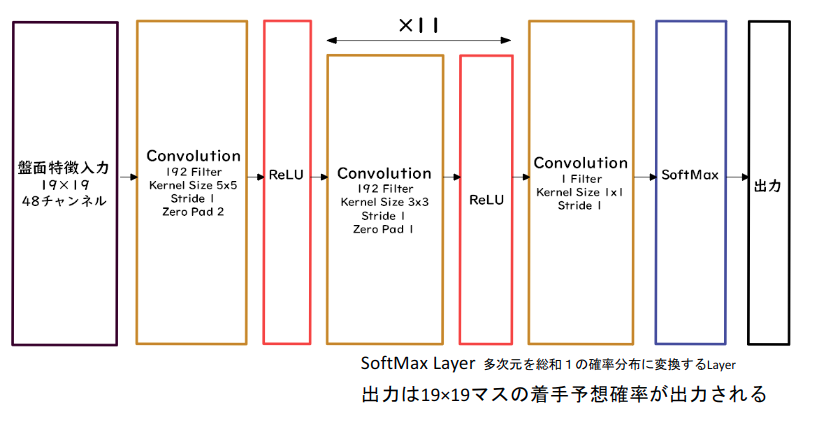

### ValueNet

PolicyNetを使用して対局シミュレーションを行い、その結果の勝敗を教師として学習

手順:
1. SL PolicyNet(教師あり学習で作成したPolicyNet)でN手まで打つ
2. N+1手目の手をランダムに選択し、その手で進めた局面をS（N+1）とする
3. S（N+1）からRLPolicyNet（強化学習で作成したPolicyNet）で終局まで打ち、その勝敗報酬をRとする

S(N+1）とRを教師データ対とし、損失関数を平均二乗誤差とし、回帰問題として学習

学習はminibatch size 32で5000万回

N手までとN+1手からのPolicyNetを別々にしてある理由は、過学習を防ぐためであると論文では説明されている

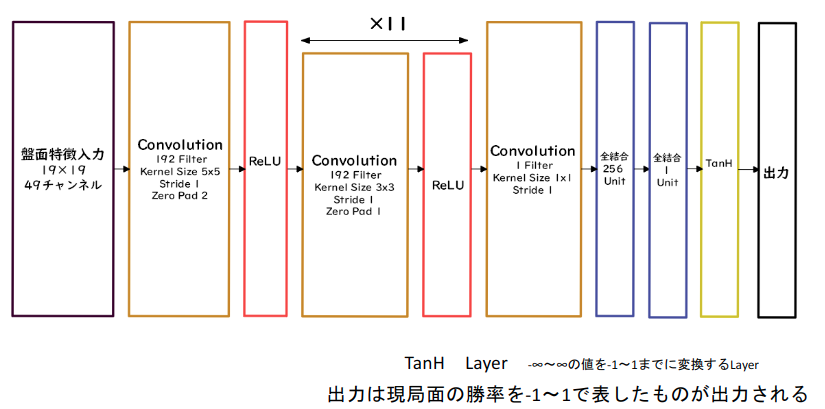

### Alpha Go (Lee) のモンテカルロ木探索

選択、評価、バックアップ、成長という４つのステップで構成

1. 選択
  - Root局面にて着手選択方策を以下に従い選択する。
  $$
  \pi=Q(s,a)+cP(s,a)\frac{\sqrt{\sum_bN(s,b)}}{a+N(s,a)}
  $$
    - $c$: 定数
    - $P(s,a)$: PolicyNetによる選択確率
    - $N(s,a)$: その手が探索中に選ばれた数
    - $\sum_b N(s,b)$: 現局面の全合法手が選ばれた数の合計
  - 上記の式は
    - $Q(s,a)$:現状の勝敗期待値
    - $cP(s,a)\frac{\sqrt{\sum_bN(s,b)}}{a+N(s,a)}$: バイアス項
  - 基本的には勝敗期待値のより高い手を選択するが、選択数が少ない手には高いバイアスがかかり、選択されやすくなる。
  - 従来のモンテカルロ木探索ではP(s,a)がバイアス項にそもそもないものや、人間が手作業で作ったヒューリスティックな方策評価が使われていたが、これにPolicyNetを使用する。
  - 選択、着手をLeafノードに到達するまで行う

2. 評価
  - 着手選択方策によって選ばれた手で進めた局面$sa$がLeafノードであればその局面saをValueNetで評価する
3. バックアップ
  - 評価フェイズで評価した値を積算する。
  - 局面saでのValueNetの評価の積算値Wv、RollOutでの勝敗値での積算値Wrが積算され、$N(s,a)$と$\sum_b N(s,b)$が１加算される。\
    -> れらの値から勝敗期待値が再計算される。\
    -> これをRoot局面までさかのぼって更新する
    $$
    Q(s,a)=(1-\lambda)\frac{Wv}{N(s,a)}a+\lambda\frac{Wr}{N(s,a)}
    $$
    - $\lambda$: $0\le\lambda\le1$の定数
      -  AlphaGoLeeでは0.5
4. 成長
  - 選択、評価、バックアップを繰り返し一定回数選択された手があったら、その手で進めた局面の合法手ノードを展開し、探索木を成長させる。

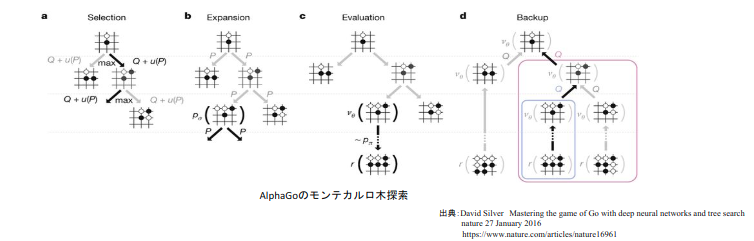

## Alpha Go Zero

### AlphaGo(Lee) とAlphaGoZeroの違い

1. 教師あり学習を一切行わず、強化学習のみで作成
2. 特徴入力からヒューリスティックな要素を排除し、石の配置のみにした
3. PolicyNetとValueNetを１つのネットワークに統合
4. Residual Netを導入
5. モンテカルロ木探索からRollOutシミュレーションをなくした

### PolicyValueNet

1つの入力で方策関数と行動価値関数の2つの出力を行うようにした。

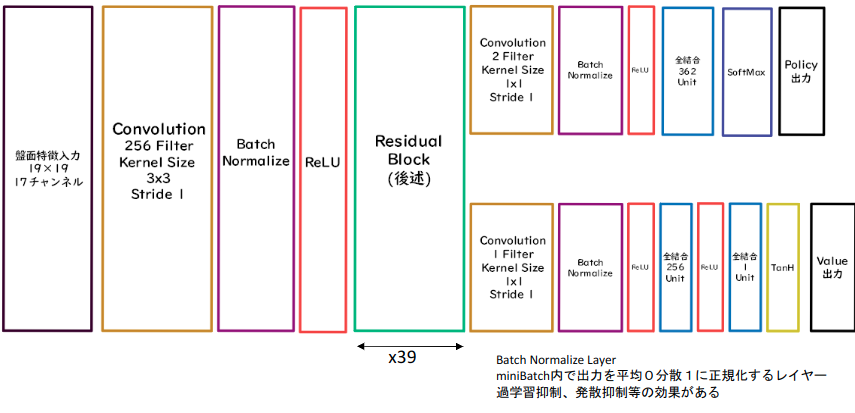

### Residual Network

- ネットワークにショートカット構造を追加して、勾配の爆発、消失を抑える効果を狙ったもの
- Residula Networkを使うことにより、100層を超えるネットワークでの安定した学習が可能となった
- 基本構造は以下を１単位にして積み重ねる
  1. Convolution
  2. BatchNorm
  3. ReLU
  4. Convolution
  5. BatchNorm
  6. Add
  7. ReLUのBlock
- Resisual Networkを使うことにより層数の違うNetworkのアンサンブル効果が得られているという説も

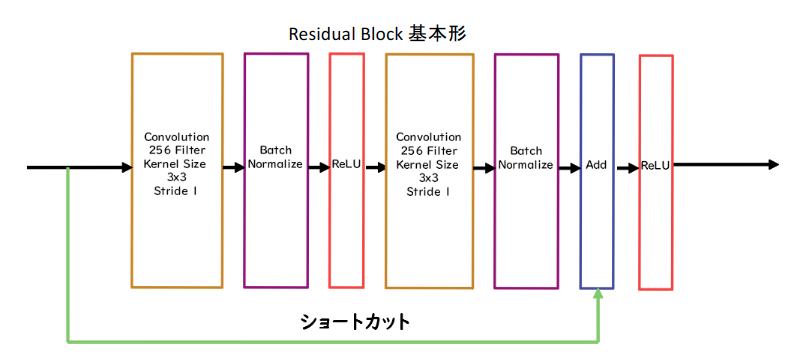

性能は従来のVGG-16と比較してTop5で4%程度ものエラー率の低減に成功している

#### 派生形

##### Residual Blockの工夫

###### Bottleneck

1×1KernelのConvolutionを利用し、1層目で次元削減を行って3層目で次元を復元する３層構造にし、２層のものと比べて計算量はほぼ同じだが１層増やせるメリットがある、としたもの

https://arxiv.org/abs/1512.03385

###### PreActivation

ResidualBlockの並びをBatchNorm->ReLU->Convolution->BatchNorm->ReLU->Convolution->Addとすることにより性能が上昇したとするもの

https://arxiv.org/abs/1603.05027

##### Network構造の工夫

###### WideResNet

ConvolutionのFilter数をk倍にしたResNet。\
１倍->k倍ｘブロック→2*k倍yブロックと段階的に幅を増やしていくのが一般的。\
Filter数を増やすことにより、浅い層数でも深い層数のものと同等以上の精度となり、またGPUをより効率的に使用できるため学習も早い

https://arxiv.org/abs/1605.07146

###### PyramidNet

WideResNetで幅が広がった直後の層に過度の負担がかかり精度を落とす原因となっているとし、段階的にではなく、各層でFilter数を増やしていくResNet。

https://arxiv.org/abs/1610.02915

https://github.com/jhkim89/PyramidNet

### Alpha Go Zeroのモンテカルロ木探索

選択、評価および成長、バックアップという３つのステップで構成
1. 選択
  - Root局面にて着手選択方策を以下に従い選択する。
  $$
  \pi=Q(s,a)+cP(s,a)\frac{\sqrt{\sum_bN(s,b)}}{a+N(s,a)}
  $$
  - 選択された合法手aで進めた局面がLeafノードでなければ、そのノードの着手選択方策に従って選択を行い、局面を進める。
  - 選択された合法手aで進めた局面がLeafノードであれば評価および成長ステップに移行する。
2. 評価及び成長
  - Leafノードまで進めた局面saをPolicyValueNetで評価する。
    - <font color="red">RollOutは行わない。</font>
  - 局面saの合法手ノードを展開し木を成長させる。
3. バックアップ

### Alpha Go Zeroの学習法

自己対局による教師データの作成、学習、ネットワークの更新の３ステップで構成

- 自己対局による教師データの作成
  - 現状のネットワークでモンテカルロ木探索を用いて自己対局を行う。
  - まず30手までランダムで打ち、そこから探索を行い勝敗を決定する。
  - 自己対局中の各局面での着手選択確率分布と勝敗を記録する。
  - 教師データの形は（局面、着手選択確率分布、勝敗）が１セットとなる。
- 学習
  - 自己対局で作成した教師データを使い学習を行う。
  - NetworkのPolicy部分の教師に着手選択確率分布を用い、Value部分の教師に勝敗を用いる。
  - 損失関数はPolicy部分はCrossEntropy、Value部分は平均二乗誤差。
- ネットワークの更新
  - 学習後、現状のネットワークと学習後のネットワークとで対局テストを行い、学習後のネットワークの勝率が高かった場合、学習後のネットワークを現状のネットワークとする。

## 補足

### モンテカルロ木探索


コンピュータ囲碁ソフトでは現在もっとも有効とされている探索法

他のボードゲームではminmax探索やその派生形の$\alpha\beta$探索を使うことが多いが、盤面の価値や勝率予想値が必要\
->囲碁では盤面の価値や勝率予想値を出すのが困難。

そこで、、\
盤面評価値に頼らず末端評価値、つまり勝敗のみを使って探索を行うことができないか、という発想で生まれた探索法

囲碁の場合、他のボードゲームと違い最大手数はマスの数でほぼ限定されるため、末端局面に到達しやすい。

- 現局面から末端局面までPlayOutと呼ばれるランダムシミュレーションを多数回行い、その勝敗を集計して着手の優劣を決定する

- 該当手のシミュレーション回数が一定数を超えたら、その手を着手したあとの局面をシミュレーション開始局面とするよう、探索木を成長させる。。

モンテカルロ木探索はこの木の成長を行うことによって、一定条件下において探索結果は最善手を返すということが理論的に証明されている。

